# Garbage Classification

In [1]:
import os
import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision
from torchvision import transforms, datasets, models

from torchvision.models import resnet34

from transformers import BertTokenizer
from transformers import BertModel

from sklearn.utils.class_weight import compute_class_weight

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


### Define Data Directories

In [2]:
trainset_dir = 'data/enel645_2024f/garbage_data/CVPR_2024_dataset_Train'
valset_dir = 'data/enel645_2024f/garbage_data/CVPR_2024_dataset_Val'
testset_dir = 'data/enel645_2024f/garbage_data/CVPR_2024_dataset_Test'


#trainset_dir = 'C:/Users/Shaakira Gadiwan/Documents/enel645/Garbage-Classification/data/garbage_data/CVPR_2024_dataset_Train'
#valset_dir = 'C:/Users/Shaakira Gadiwan/Documents/enel645/Garbage-Classification/data/garbage_data/CVPR_2024_dataset_Val'
#testset_dir = 'C:/Users/Shaakira Gadiwan/Documents/enel645/Garbage-Classification/data/garbage_data/CVPR_2024_dataset_Test'

### Define Garbage Dataset Class

In [3]:
class GarbageDataset(Dataset):
    def __init__(self, dataframe, image_transform=None, max_len=32, class_to_idx=None):
        self.dataframe = dataframe
        self.image_transform = image_transform
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.max_len = max_len
        self.class_to_idx = class_to_idx  # Pass the class mapping

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get image path, text description, and label from the dataframe
        img_path = self.dataframe.iloc[idx]['image_path']
        text_desc = self.dataframe.iloc[idx]['text_description']
        label = self.dataframe.iloc[idx]['label']  

        # Load and preprocess the image
        image = Image.open(img_path).convert("RGB")
        if self.image_transform:
            image = self.image_transform(image)

        # Tokenize the text description
        text_inputs = self.tokenizer(
            text_desc, 
            padding='max_length', 
            truncation=True, 
            max_length=self.max_len, 
            return_tensors="pt"
        )

        # Convert string label to numeric label using the class mapping
        numeric_label = self.class_to_idx[label]

        # Return the image, text input, and numeric label
        return {
            'image': image,
            'input_ids': text_inputs['input_ids'].squeeze(0),  
            'attention_mask': text_inputs['attention_mask'].squeeze(0),  
            'label': torch.tensor(numeric_label, dtype=torch.long)  
        }

### Define Methods

In [4]:
# Extract images, labels, and text descriptions from a given folder
def extract_data_from_folders(base_dir):
    data = []

    # Traverse through each subfolder
    for label_folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, label_folder)

        # Check if it's a directory
        if os.path.isdir(folder_path):
            # Loop through each image file in the subfolder
            for filename in os.listdir(folder_path):
                if filename.endswith(('.jpg', '.png', '.jpeg')):  # Filter image files
                    image_path = os.path.join(folder_path, filename)

                    # Extract text from filename (remove file extension)
                    text_description = os.path.splitext(filename)[0]

                    # Append image path, text, and label to the data list
                    data.append({
                        'image_path': image_path,
                        'text_description': text_description,
                        'label': label_folder  # The subfolder name represents the label (bin)
                    })

    # Convert to DataFrame for easy manipulation
    return pd.DataFrame(data)

### Custom activation

In [5]:
# Define custom activation function (Modified Swish)
class CustomActivation(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(torch.log(1 + torch.abs(x)))

In [6]:
# Define the modified ResNet-34
class ModifiedResNet34(nn.Module):
    def __init__(self):
        super(ModifiedResNet34, self).__init__()
        self.base_model = models.resnet34(pretrained=True)
        self.base_model.fc = nn.Identity()  # Remove the final classification layer
        self.activation = CustomActivation()

    def forward(self, x):
        x = self.base_model.conv1(x)
        x = self.base_model.bn1(x)
        x = self.activation(x)
        x = self.base_model.layer1(x)
        x = self.base_model.layer2(x)
        x = self.base_model.layer3(x)
        x = self.base_model.layer4(x)
        x = self.base_model.avgpool(x)
        x = torch.flatten(x, 1)  # Resulting in a [batch_size, 512] tensor
        return x

### Define Multi Modal Classifier

In [11]:
# class CombinedClassifier(nn.Module):
#     def __init__(self, image_model, text_model, combined_feature_size, num_classes):
#         super(CombinedClassifier, self).__init__()
#         self.image_model = image_model  # Pre-trained ResNet model
#         self.text_model = text_model    # Pre-trained BERT model
#         self.fc = nn.Linear(combined_feature_size, num_classes)  # Final classifier

#     def forward(self, image, text_input_ids, text_attention_mask):
#         # Get image features from the ResNet model
#         image_features = self.image_model(image)
        
#         # Get text features from the BERT model
#         text_features = self.text_model(input_ids=text_input_ids, attention_mask=text_attention_mask).pooler_output
        
#         # Combine image and text features
#         combined_features = torch.cat((image_features, text_features), dim=1)
        
#         # Pass combined features through the classifier
#         output = self.fc(combined_features)
#         return output

In [7]:
class GarbageClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super(GarbageClassifier, self).__init__()
        # Image feature extraction with ResNet
        self.resnet = ModifiedResNet34()
        # Text feature extraction with BERT
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        # Classification layer after combining image and text features
        self.fc_combined = nn.Linear(512 + 768, num_classes)
        # Separate classification layers for image and text outputs
        self.fc_image = nn.Linear(512, num_classes)
        self.fc_text = nn.Linear(768, num_classes)

    def forward(self, image, input_ids, attention_mask):
        # Get image features from ResNet
        image_features = self.resnet(image)
        # Get text features from BERT
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_features = bert_output.pooler_output  # (batch_size, 768)

        # Separate predictions for image and text
        image_output = self.fc_image(image_features)  # Classification based on image alone
        text_output = self.fc_text(text_features)  # Classification based on text alone

        # Combined features from both image and text
        combined_features = torch.cat((image_features, text_features), dim=1)
        combined_output = self.fc_combined(combined_features)

        return image_output, text_output, combined_output

In [8]:
run = wandb.init(project='garbage-collection')

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: tahmidkazi829 (tahmidkazi829-university-of-calgary-in-alberta). Use `wandb login --relogin` to force relogin


In [9]:
# Define classes and map them to indices
class_names = ['Green', 'Blue', 'Black', 'TTR']  
class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}
idx_to_class = {idx: class_name for idx, class_name in enumerate(class_names)}

In [10]:
# Extract the data
trainset_df = extract_data_from_folders(trainset_dir)
valset_df = extract_data_from_folders(valset_dir)
testset_df = extract_data_from_folders(testset_dir)

# Print the first few rows of the DataFrames
print(trainset_df.head())
print(valset_df.head())
print(testset_df.head())

                                          image_path  \
0  data/enel645_2024f/garbage_data/CVPR_2024_data...   
1  data/enel645_2024f/garbage_data/CVPR_2024_data...   
2  data/enel645_2024f/garbage_data/CVPR_2024_data...   
3  data/enel645_2024f/garbage_data/CVPR_2024_data...   
4  data/enel645_2024f/garbage_data/CVPR_2024_data...   

                 text_description  label  
0  acne_treatment_ointment_tube_0  Black  
1              Aero_bar_wrapper_1  Black  
2       air_freshener_container_2  Black  
3                  almonds_sack_4  Black  
4            aloe_vera_gel_tube_5  Black  
                                          image_path        text_description  \
0  data/enel645_2024f/garbage_data/CVPR_2024_data...  air_freshener_refill_3   
1  data/enel645_2024f/garbage_data/CVPR_2024_data...             apple pouch   
2  data/enel645_2024f/garbage_data/CVPR_2024_data...       a_bag_of_chips_22   
3  data/enel645_2024f/garbage_data/CVPR_2024_data...          babybel_wax_30   
4  da

### Data Visualization

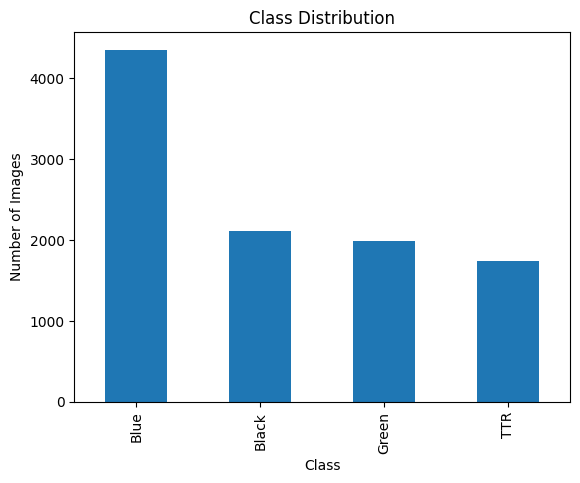

In [12]:
class_counts = trainset_df['label'].value_counts() 
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

In [13]:
# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

trainset = GarbageDataset(trainset_df, image_transform=transform, class_to_idx=class_to_idx)
valset = GarbageDataset(valset_df, image_transform=transform, class_to_idx=class_to_idx)
testset = GarbageDataset(testset_df, image_transform=transform, class_to_idx=class_to_idx)

# Example: Access a sample from the training dataset
sample = trainset[0]
print(sample['image'].shape)  # (3, 224, 224)
print(sample['input_ids'].shape)  # (32,) - max_len of 32 tokens
print(sample['label'])  # The label as a tensor



torch.Size([3, 224, 224])
torch.Size([32])
tensor(2)


In [14]:
batch_size = 32

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=6)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=6)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=6)

In [15]:
# # Load a pre-trained models for image and text feature extraction
# image_model = models.resnet18(pretrained=True)
# text_model = BertModel.from_pretrained('bert-base-uncased')

# # Freeze the feature-extracting layers if desired
# for name, param in image_model.named_parameters():
#     if 'layer4' in name or 'fc' in name:  # Unfreeze layer4 and the final fully connected layer, layer 4 is the last convolutional block and should be fine tuned...
#         param.requires_grad = True
#     else:
#         param.requires_grad = False  # Freeze all other layers

# for param in text_model.parameters():
#     param.requires_grad = True # not sure which layers to freeze

# # Replace the final fully connected layer to match the number of required outputs for our problem
# num_image_features = image_model.fc.in_features
# image_model.fc = nn.Linear(num_image_features, len(class_names))

# # Create the combined image and text model
# combined_feature_size = num_image_features + 768  # 768 is the BERT hidden size
# combined_model = CombinedClassifier(image_model, text_model, combined_feature_size, len(class_names)).to(device)

# image_model = image_model.to(device)
# print(image_model)

In [16]:
# fixing class weights
class_weights = compute_class_weight('balanced', classes=np.unique(trainset_df['label']), y=trainset_df['label'])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Initialize the model, loss function, and optimizer
model = GarbageClassifier(num_classes=len(class_names)).to(device)

# Freeze all ResNet layers
for param in model.resnet.parameters():
    param.requires_grad = False

# Unfreeze the last ResNet block
for param in model.resnet.base_model.layer4.parameters():
    param.requires_grad = True

# Optionally, unfreeze BatchNorm layers to allow them to adapt to your data
for module in model.resnet.modules():
    if isinstance(module, nn.BatchNorm2d):
        for param in module.parameters():
            param.requires_grad = True

# Freeze all BERT layers
for param in model.bert.parameters():
    param.requires_grad = False

# Unfreeze the last BERT encoder layer
for param in model.bert.encoder.layer[-1].parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

c:\Users\tahmi\anaconda3\envs\enel-645\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\tahmi\anaconda3\envs\enel-645\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:

num_epochs = 10
wandb.config = {"epochs": num_epochs, "batch_size": batch_size, "learning_rate": 0.001}

best_val_acc = 0.0  # Variable to track the best validation accuracy

for epoch in range(wandb.config['epochs']):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)
    
    # Training phase
    model.train()
    running_loss_image = 0.0
    running_loss_text = 0.0
    running_loss_combined = 0.0
    running_corrects_image = 0
    running_corrects_text = 0
    running_corrects_combined = 0
    
    for i, batch in enumerate(trainloader, 0):
        images = batch['image'].to(device)
        text_input_ids = batch['input_ids'].to(device)
        text_attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()

        # Forward pass (separate outputs)
        image_output, text_output, combined_output = model(images, text_input_ids, text_attention_mask)
        
        # Compute loss for image, text, and combined models
        loss_image = criterion(image_output, labels)
        loss_text = criterion(text_output, labels)
        loss_combined = criterion(combined_output, labels)
        
        # Backward pass and optimization
        total_loss = loss_image + loss_text + loss_combined
        total_loss.backward()
        optimizer.step()

        # Update running loss and accuracy for image, text, and combined
        running_loss_image += loss_image.item() * images.size(0)
        running_loss_text += loss_text.item() * images.size(0)
        running_loss_combined += loss_combined.item() * images.size(0)
        
        _, preds_image = torch.max(image_output, 1)
        _, preds_text = torch.max(text_output, 1)
        _, preds_combined = torch.max(combined_output, 1)

        running_corrects_image += torch.sum(preds_image == labels.data)
        running_corrects_text += torch.sum(preds_text == labels.data)
        running_corrects_combined += torch.sum(preds_combined == labels.data)
    
    # Compute epoch loss and accuracy for image, text, and combined
    epoch_loss_image = running_loss_image / len(trainset)
    epoch_loss_text = running_loss_text / len(trainset)
    epoch_loss_combined = running_loss_combined / len(trainset)
    
    epoch_acc_image = running_corrects_image.double() / len(trainset)
    epoch_acc_text = running_corrects_text.double() / len(trainset)
    epoch_acc_combined = running_corrects_combined.double() / len(trainset)

    print(f'Training Loss (Image): {epoch_loss_image:.4f} Acc (Image): {epoch_acc_image:.4f}')
    print(f'Training Loss (Text): {epoch_loss_text:.4f} Acc (Text): {epoch_acc_text:.4f}')
    print(f'Training Loss (Combined): {epoch_loss_combined:.4f} Acc (Combined): {epoch_acc_combined:.4f}')
    
    wandb.log({
        "Training Loss (Image)": epoch_loss_image, 
        "Training Accuracy (Image)": epoch_acc_image,
        "Training Loss (Text)": epoch_loss_text, 
        "Training Accuracy (Text)": epoch_acc_text,
        "Training Loss (Combined)": epoch_loss_combined, 
        "Training Accuracy (Combined)": epoch_acc_combined
    })
    
    # Validation phase (same structure as training phase)
    model.eval()
    val_running_loss_image = 0.0
    val_running_loss_text = 0.0
    val_running_loss_combined = 0.0
    val_running_corrects_image = 0
    val_running_corrects_text = 0
    val_running_corrects_combined = 0
    
    with torch.no_grad():
        for batch in valloader:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Forward pass (separate outputs)
            image_output, text_output, combined_output = model(images, input_ids, attention_mask)
            
            # Compute loss for image, text, and combined models
            loss_image = criterion(image_output, labels)
            loss_text = criterion(text_output, labels)
            loss_combined = criterion(combined_output, labels)
            
            # Update running loss and accuracy for image, text, and combined
            val_running_loss_image += loss_image.item() * images.size(0)
            val_running_loss_text += loss_text.item() * images.size(0)
            val_running_loss_combined += loss_combined.item() * images.size(0)
            
            _, preds_image = torch.max(image_output, 1)
            _, preds_text = torch.max(text_output, 1)
            _, preds_combined = torch.max(combined_output, 1)

            val_running_corrects_image += torch.sum(preds_image == labels.data)
            val_running_corrects_text += torch.sum(preds_text == labels.data)
            val_running_corrects_combined += torch.sum(preds_combined == labels.data)
    
    # Compute validation loss and accuracy for image, text, and combined
    val_loss_image = val_running_loss_image / len(valset)
    val_loss_text = val_running_loss_text / len(valset)
    val_loss_combined = val_running_loss_combined / len(valset)
    
    val_acc_image = val_running_corrects_image.double() / len(valset)
    val_acc_text = val_running_corrects_text.double() / len(valset)
    val_acc_combined = val_running_corrects_combined.double() / len(valset)

    print(f'Validation Loss (Image): {val_loss_image:.4f} Acc (Image): {val_acc_image:.4f}')
    print(f'Validation Loss (Text): {val_loss_text:.4f} Acc (Text): {val_acc_text:.4f}')
    print(f'Validation Loss (Combined): {val_loss_combined:.4f} Acc (Combined): {val_acc_combined:.4f}')
    
    wandb.log({
        "Validation Loss (Image)": val_loss_image, 
        "Validation Accuracy (Image)": val_acc_image,
        "Validation Loss (Text)": val_loss_text, 
        "Validation Accuracy (Text)": val_acc_text,
        "Validation Loss (Combined)": val_loss_combined, 
        "Validation Accuracy (Combined)": val_acc_combined
    })

    if val_acc_combined > best_val_acc:
        best_val_acc = val_acc_combined
        print(f"New best model found! Saving model with validation accuracy: {best_val_acc:.4f}")
        torch.save(model.state_dict(), 'best_garbage_model.pth')


Epoch 1/10
----------


In [ ]:
model.load_state_dict(torch.load('best_garbage_model.pth'))
model.eval()
test_running_corrects = 0
with torch.no_grad():
    for batch in testloader:
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(images, input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, 1)
        test_running_corrects += torch.sum(preds == labels.data)
test_acc = test_running_corrects.double() / len(testset)
print(f'Test Accuracy: {test_acc:.4f}')
wandb.log({"Test Accuracy": test_acc})

In [ ]:
wandb.finish()